In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def preparar_dados(df):
    """Prepara os dados iniciais"""
    # Converter data
    df['data_pregao'] = pd.to_datetime(df['data_pregao'])
    
    # Ordenar por ação e data
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro (52 semanas)
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].pct_change(periods=52)
    
    return df

def extrair_features(df):
    """Extrai features de forma vetorizada com tratamento de divisão por zero"""
    df = df.copy()
    
    # Agrupa por ação para cálculos de janela
    gb = df.groupby('cod_negociacao')['preco_fechamento']
    
    # Médias móveis e volatilidade
    for window in [4, 8, 12, 26]:
        df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
    
    # Retornos em diferentes janelas - com tratamento para preço zero
    for weeks, periods in [(4,3), (12,11), (26,25)]:
        preco_passado = gb.shift(periods)
        # Calcula retorno com tratamento para divisão por zero
        retorno = np.where(
            (preco_passado > 0.001),  # Considera apenas se preço passado > 0.001
            (df['preco_fechamento'] / preco_passado) - 1,
            np.nan  # Retorna NA se preço passado for zero ou muito pequeno
        )
        df[f'retorno_{weeks}w'] = retorno
    
    # Features de volume
    vol_gb = df.groupby('cod_negociacao')['volume']
    for window in [4, 12]:
        df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
    
    # Momentum
    df['momento_4_12'] = df['retorno_4w'] - df['retorno_12w']
    
    df.shape
    
    return df

def preprocessamento_pipeline():
    """Cria pipeline de pré-processamento"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

def treinar_modelo(df):
    """Treina o modelo com validação temporal"""
    # Preparar dados
    df = preparar_dados(df)
    df = extrair_features(df)
    
    # Remover NA gerados pelas janelas e retorno futuro
    df = df.dropna(subset=['retorno_futuro'])
    
    # Separar features e target
    features = ['media_4w', 'media_12w', 'vol_4w', 'vol_12w', 
                'retorno_4w', 'retorno_12w', 'volume_medio_4w',
                'momento_4_12']
    
    X = df[features]
    y = df['retorno_futuro']
    
    # Tratar infinitos e NA
    X = X.replace([np.inf, -np.inf], np.nan)
    y = y.loc[X.index]
    
    # Pipeline de modelagem
    pipeline = Pipeline([
        ('preprocess', preprocessamento_pipeline()),
        ('model', RandomForestRegressor(n_estimators=200, 
                                      random_state=42,
                                      n_jobs=-1))
    ])
    
    # Validação cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        print(f"Score R²: {score:.4f}")
    
    return pipeline

# Carregar dados
df_semanal = pd.read_csv("semanal2021-2022.csv")

# Treinar modelo
modelo = treinar_modelo(df_semanal)

ValueError: Input y contains infinity or a value too large for dtype('float64').

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

def preparar_dados(df):
    """Prepara os dados iniciais com tratamento robusto do target"""
    # Converter data
    df['data_pregao'] = pd.to_datetime(df['data_pregao'])
    
    # Ordenar por ação e data
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro de forma segura
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Remover retornos extremos (outliers)
    df['retorno_futuro'] = df['retorno_futuro'].clip(
        lower=df['retorno_futuro'].quantile(0.01),
        upper=df['retorno_futuro'].quantile(0.99)
    )
    
    return df

def extrair_features(df):
    """Extrai features com tratamento completo de infinitos e NA"""
    df = df.copy()
    
    # Garantir ordenação
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Grupo para cálculos
    gb = df.groupby('cod_negociacao')['preco_fechamento']
    
    # Função segura para retornos
    def safe_return(current, past, min_price=0.01):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.where(
                (past > min_price) & (current > min_price),
                (current - past) / past,
                np.nan
            )
    
    # Médias móveis
    for window in [4, 8, 12, 26]:
        df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
    
    # Retornos protegidos
    for weeks, periods in [(4,3), (12,11), (26,25)]:
        preco_passado = gb.shift(periods)
        df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
    
    # Volume médio
    vol_gb = df.groupby('cod_negociacao')['volume']
    for window in [4, 12]:
        df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
    
    # Momentum com fillna
    df['momento_4_12'] = (df['retorno_4w'].fillna(0) - df['retorno_12w'].fillna(0))
    
    return df

def clean_data(X, y):
    """Limpeza final dos dados antes do treino"""
    # Juntar X e y para limpeza consistente
    data = X.copy()
    data['target'] = y
    
    # Remover infinitos e NA
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    
    # Separar novamente
    X_clean = data.drop('target', axis=1)
    y_clean = data['target']
    
    return X_clean, y_clean

def treinar_modelo(df):
    """Função final de treino com todas as proteções"""
    # Preparação dos dados
    df = preparar_dados(df)
    df = extrair_features(df)
    
    # Features selecionadas
    features = ['media_4w', 'media_12w', 'vol_4w', 'vol_12w', 
                'retorno_4w', 'retorno_12w', 'volume_medio_4w',
                'momento_4_12']
    
    X = df[features]
    y = df['retorno_futuro']
    
    # Limpeza final
    X, y = clean_data(X, y)
    
    # Pipeline robusto
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            max_depth=5  # Limite de profundidade para evitar overfitting
        ))
    ])
    
    # Validação cruzada temporal
    tscv = TimeSeriesSplit(n_splits=3)  # Reduzido para 3 por performance
    
    print(f"Shape final dos dados: {X.shape}")
    print(f"Valores únicos no target: {pd.Series(y).describe()}")
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        print(f"Score R²: {score:.4f}")
    
    return pipeline

# Carregar dados
df_semanal = pd.read_csv("semanal2021-2022.csv")

# Treinar modelo
modelo = treinar_modelo(df_semanal)

Shape final dos dados: (90838, 8)
Valores únicos no target: count    90838.000000
mean        -0.162388
std          0.417102
min         -0.958333
25%         -0.392035
50%         -0.172221
75%          0.000139
max          2.000000
Name: target, dtype: float64
Score R²: 0.1506
Score R²: 0.2112
Score R²: 0.1979


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Classe para extração avançada de features sem TA-Lib"""
    def __init__(self):
        self.features_to_use = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Garantir ordenação correta
        df = df.sort_values(['cod_negociacao', 'data_pregao'])
        
        # Grupo para cálculos
        gb = df.groupby('cod_negociacao')['preco_fechamento']
        
        # 1. Features básicas
        for window in [4, 8, 12, 26]:
            df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
            df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
        
        # 2. Retornos com tratamento robusto
        def safe_return(current, past, min_price=0.01):
            with np.errstate(divide='ignore', invalid='ignore'):
                return np.where(
                    (past > min_price) & (current > min_price),
                    (current - past) / past,
                    np.nan
                )
        
        for weeks, periods in [(1,0), (4,3), (12,11), (26,25)]:
            preco_passado = gb.shift(periods)
            df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
        
        # 3. Implementação simplificada de RSI sem TA-Lib
        def calculate_rsi(series, window=14):
            delta = series.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()
            
            rs = avg_gain / avg_loss
            return 100 - (100 / (1 + rs))
        
        df['rsi_14'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(calculate_rsi)
        
        # 4. Features temporais
        for lag in [1, 2, 3, 4]:
            df[f'retorno_lag_{lag}w'] = df.groupby('cod_negociacao')['retorno_1w'].shift(lag)
        
        df['ema_12'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.ewm(span=12).mean()
        )
        
        # 5. Features de volume
        vol_gb = df.groupby('cod_negociacao')['volume']
        for window in [4, 12]:
            df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        
        # 6. Features setoriais/relativas (se disponível)
        if 'setor' in df.columns:
            df['retorno_relativo'] = df.groupby(['data_pregao', 'setor'])['retorno_4w'].transform('mean')
            df['vol_relativa'] = df['vol_4w'] / df.groupby('data_pregao')['vol_4w'].transform('mean')
        
        # Definir features a serem usadas
        self.features_to_use = [
            'media_4w', 'media_12w', 'vol_4w', 'vol_12w',
            'retorno_1w', 'retorno_4w', 'retorno_12w',
            'retorno_lag_1w', 'retorno_lag_2w',
            'volume_medio_4w', 'ema_12', 'rsi_14'
        ]
        
        if 'retorno_relativo' in df.columns:
            self.features_to_use.extend(['retorno_relativo', 'vol_relativa'])
        
        return df

# [O resto do código permanece igual a partir da função preparar_target()...]

def preparar_target(df):
    """Prepara o target com tratamento robusto"""
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Tratar outliers extremos
    lower = df['retorno_futuro'].quantile(0.01)
    upper = df['retorno_futuro'].quantile(0.99)
    df['retorno_futuro'] = df['retorno_futuro'].clip(lower, upper)
    
    return df

# [Continue com as outras funções: clean_data, criar_pipeline, avaliar_modelo, plot_feature_importance, main]
def clean_data(X, y):
    """Limpeza final dos dados"""
    data = X.join(y)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    return data.drop('retorno_futuro', axis=1), data['retorno_futuro']

def criar_pipeline():
    """Cria pipeline de modelagem avançada"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', HistGradientBoostingRegressor(
            max_iter=200,
            learning_rate=0.05,
            max_depth=7,
            early_stopping=True,
            random_state=42,
            scoring='r2'
        ))
    ])

def avaliar_modelo(X, y):
    """Avaliação robusta com validação cruzada temporal"""
    modelo = criar_pipeline()
    tscv = TimeSeriesSplit(n_splits=3)
    
    scores = cross_val_score(
        modelo, X, y,
        cv=tscv,
        scoring='r2',
        n_jobs=-1
    )
    
    print("\nResultados da Validação Cruzada:")
    for i, score in enumerate(scores):
        print(f"Fold {i+1}: R² = {score:.4f}")
    print(f"Média R²: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    
    return scores

def plot_feature_importance(modelo, feature_names):
    """Visualização correta da importância das features para qualquer modelo"""
    try:
        # Verifica se é um pipeline ou modelo direto
        if hasattr(modelo, 'named_steps'):
            model = modelo.named_steps['model']
        else:
            model = modelo
        
        # Obtém as importâncias de forma genérica
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
        else:
            print("Modelo não possui atributo de importância de features")
            return
        
        # Ordena as features por importância
        indices = np.argsort(importances)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.title('Importância das Features')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Importância Relativa')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Erro ao plotar importância: {str(e)}")

def main(file_path):
    """Função principal para execução completa sem TA-Lib"""
    # 1. Carregar dados
    print("Carregando dados...")
    df = pd.read_csv(file_path)
    
    # 2. Preparar target
    print("\nPreparando target...")
    df = preparar_target(df)
    
    # 3. Extrair features
    print("\nExtraindo features...")
    feature_extractor = FeatureExtractor()
    df_features = feature_extractor.transform(df)
    
    # 4. Selecionar dados finais
    X = df_features[feature_extractor.features_to_use]
    y = df_features['retorno_futuro']
    
    # 5. Limpeza final
    print("\nLimpando dados...")
    X_clean, y_clean = clean_data(X, y)
    
    print(f"\nShape final dos dados: {X_clean.shape}")
    print(f"Distribuição do target:\n{y_clean.describe()}")
    
    # 6. Avaliar modelo
    print("\nAvaliando modelo...")
    scores = avaliar_modelo(X_clean, y_clean)
    
    # 7. Treinar modelo final
    print("\nTreinando modelo final...")
    modelo = criar_pipeline()
    modelo.fit(X_clean, y_clean)
    
    # 8. Visualizar importância das features
    plot_feature_importance(modelo, feature_extractor.features_to_use)
    
    return modelo, X_clean, y_clean

if __name__ == "__main__":
    # Executar pipeline completo sem TA-Lib
    modelo_final, X_final, y_final = main("semanal2021-2022.csv")

Carregando dados...

Preparando target...

Extraindo features...

Limpando dados...

Shape final dos dados: (90752, 12)
Distribuição do target:
count    90752.000000
mean        -0.162085
std          0.416844
min         -0.958333
25%         -0.391588
50%         -0.172014
75%          0.000265
max          2.000000
Name: retorno_futuro, dtype: float64

Avaliando modelo...

Resultados da Validação Cruzada:
Fold 1: R² = 0.1395
Fold 2: R² = 0.2309
Fold 3: R² = 0.2150
Média R²: 0.1951 (±0.0399)

Treinando modelo final...
Modelo não possui atributo de importância de features


Carregando dados...

Preparando target...

Extraindo features...

Limpando dados...

Dados finais: 90748 observações
Features: 12 variáveis

Treinando XGBoost com validação temporal...
Fold 1: R² = 0.2087 | Melhor iteração: 35
Fold 2: R² = 0.2439 | Melhor iteração: 70
Fold 3: R² = 0.2336 | Melhor iteração: 40

R² Médio: 0.2287 (±0.0148)

Treinando modelo final...


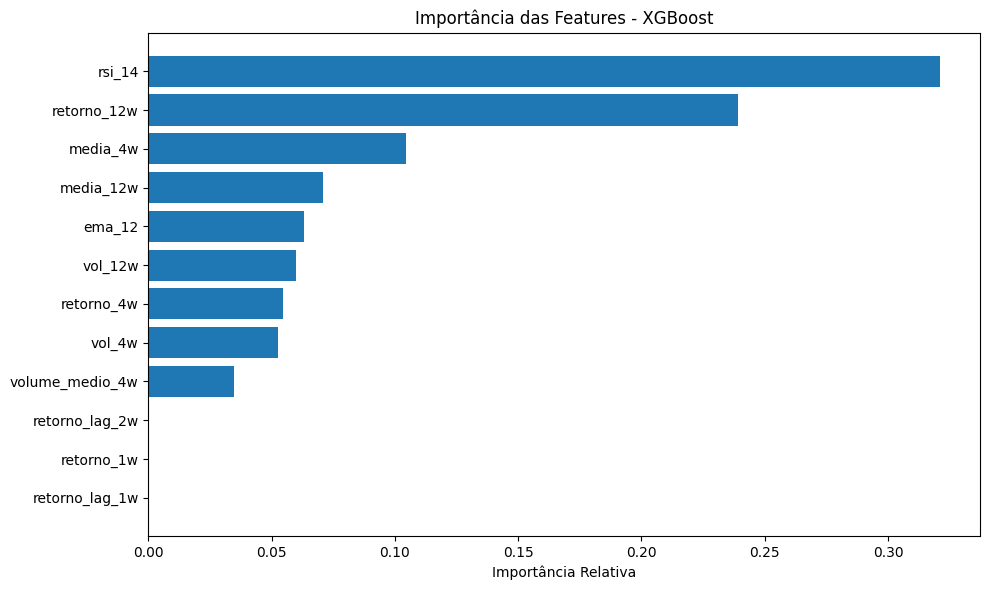


Modelo XGBoost treinado com sucesso!
Exemplo de previsão para a primeira amostra: 0.1103


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Classe para extração avançada de features"""
    def __init__(self):
        self.features_to_use = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Garantir ordenação correta
        if 'data_pregao' in df.columns:
            df['data_pregao'] = pd.to_datetime(df['data_pregao'])
            df = df.sort_values(['cod_negociacao', 'data_pregao'])
        
        # Grupo para cálculos
        gb = df.groupby('cod_negociacao')['preco_fechamento']
        
        # 1. Médias móveis e volatilidade
        for window in [4, 8, 12, 26]:
            df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
            df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
        
        # 2. Retornos protegidos contra divisão por zero
        def safe_return(current, past, min_price=0.01):
            with np.errstate(divide='ignore', invalid='ignore'):
                return np.where(
                    (past > min_price) & (current > min_price),
                    (current - past) / past,
                    np.nan
                )
        
        for weeks, periods in [(1,0), (4,3), (12,11), (26,25)]:
            preco_passado = gb.shift(periods)
            df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
        
        # 3. RSI manual (sem TA-Lib)
        def calculate_rsi(series, window=14):
            delta = series.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window, min_periods=1).mean()
            avg_loss = loss.rolling(window=window, min_periods=1).mean()
            
            rs = avg_gain / avg_loss.replace(0, np.nan)
            return 100 - (100 / (1 + rs.replace(np.inf, 100)))
        
        df['rsi_14'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(calculate_rsi)
        
        # 4. Features temporais
        for lag in [1, 2, 3, 4]:
            df[f'retorno_lag_{lag}w'] = df.groupby('cod_negociacao')['retorno_1w'].shift(lag)
        
        df['ema_12'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.ewm(span=12).mean()
        )
        
        # 5. Features de volume
        if 'volume' in df.columns:
            vol_gb = df.groupby('cod_negociacao')['volume']
            for window in [4, 12]:
                df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        
        # Definir features a serem usadas
        self.features_to_use = [
            'media_4w', 'media_12w', 'vol_4w', 'vol_12w',
            'retorno_1w', 'retorno_4w', 'retorno_12w',
            'retorno_lag_1w', 'retorno_lag_2w',
            'volume_medio_4w', 'ema_12', 'rsi_14'
        ]
        
        return df

def preparar_target(df):
    """Prepara o target com tratamento robusto"""
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro de 52 semanas
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Remover outliers extremos
    if 'retorno_futuro' in df.columns:
        lower = df['retorno_futuro'].quantile(0.01)
        upper = df['retorno_futuro'].quantile(0.99)
        df['retorno_futuro'] = df['retorno_futuro'].clip(lower, upper)
    
    return df

def clean_data(X, y):
    """Limpeza final dos dados"""
    data = X.join(y)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    return data.drop('retorno_futuro', axis=1), data['retorno_futuro']

def criar_pipeline_xgb():
    """Pipeline com XGBoost otimizado"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric='rmse'
        ))
    ])

def treinar_avaliar_xgb(X, y):
    """Treinamento e avaliação personalizada com validação temporal"""
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    modelos = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # Criar e treinar modelo
        xgb = XGBRegressor(
            n_estimators=500,  # Número maior pois usamos early stopping
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=20,
            eval_metric='rmse'
        )
        
        # Treinar com early stopping
        xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # Avaliar
        y_pred = xgb.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)
        modelos.append(xgb)
        
        print(f"Fold {len(scores)}: R² = {score:.4f} | Melhor iteração: {xgb.best_iteration}")
    
    print(f"\nR² Médio: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return modelos, scores

def plot_xgb_importance(modelo, feature_names):
    """Visualização da importância das features no XGBoost"""
    importances = modelo.feature_importances_
    
    # Cria DataFrame para melhor visualização
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance')
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feat_imp)), feat_imp['Importance'], align='center')
    plt.yticks(range(len(feat_imp)), feat_imp['Feature'])
    plt.title('Importância das Features - XGBoost')
    plt.xlabel('Importância Relativa')
    plt.tight_layout()
    plt.show()

def main(file_path):
    """Função principal"""
    try:
        # 1. Carregar dados
        print("Carregando dados...")
        df = pd.read_csv(file_path)
        
        # 2. Preparar target
        print("\nPreparando target...")
        df = preparar_target(df)
        
        # 3. Extrair features
        print("\nExtraindo features...")
        feature_extractor = FeatureExtractor()
        df_features = feature_extractor.transform(df)
        
        # 4. Selecionar dados finais
        X = df_features[feature_extractor.features_to_use]
        y = df_features['retorno_futuro']
        
        # 5. Limpeza final
        print("\nLimpando dados...")
        X_clean, y_clean = clean_data(X, y)
        
        print(f"\nDados finais: {X_clean.shape[0]} observações")
        print(f"Features: {X_clean.shape[1]} variáveis")
        
        # 6. Treinar e avaliar
        print("\nTreinando XGBoost com validação temporal...")
        modelos, scores = treinar_avaliar_xgb(X_clean, y_clean)
        
        # 7. Treinar modelo final com todos os dados
        print("\nTreinando modelo final...")
        modelo_final = XGBRegressor(
            n_estimators=int(np.mean([m.best_iteration for m in modelos])) + 20,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        modelo_final.fit(X_clean, y_clean)
        
        # 8. Visualizar importância
        plot_xgb_importance(modelo_final, feature_extractor.features_to_use)
        
        return modelo_final, X_clean, y_clean
    
    except Exception as e:
        print(f"\nErro: {str(e)}")
        return None, None, None

if __name__ == "__main__":
    # Executar pipeline
    modelo_xgb, X_data, y_data = main("semanal2021-2022.csv")
    
    if modelo_xgb is not None:
        print("\nModelo XGBoost treinado com sucesso!")
        # Exemplo de previsão
        sample_pred = modelo_xgb.predict(X_data.head(1))
        print(f"Exemplo de previsão para a primeira amostra: {sample_pred[0]:.4f}")

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score
from xgboost.callback import EarlyStopping

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Classe aprimorada para extração de features com novas métricas"""
    def __init__(self):
        self.features_to_use = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Garantir ordenação correta
        if 'data_pregao' in df.columns:
            df['data_pregao'] = pd.to_datetime(df['data_pregao'])
            df = df.sort_values(['cod_negociacao', 'data_pregao'])
        
        # Grupo para cálculos
        gb = df.groupby('cod_negociacao')['preco_fechamento']
        
        # 1. Features básicas (mantendo as mais importantes)
        for window in [4, 12, 26]:  # Removida média de 8 semanas
            df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
            df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
        
        # 2. Retornos protegidos contra divisão por zero
        def safe_return(current, past, min_price=0.01):
            with np.errstate(divide='ignore', invalid='ignore'):
                return np.where(
                    (past > min_price) & (current > min_price),
                    (current - past) / past,
                    np.nan
                )
        
        for weeks, periods in [(1,0), (4,3), (12,11)]:  # Removido retorno de 26 semanas
            preco_passado = gb.shift(periods)
            df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
        
        # 3. RSI manual aprimorado
        def calculate_rsi(series, window=14):
            delta = series.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window, min_periods=1).mean()
            avg_loss = loss.rolling(window=window, min_periods=1).mean()
            
            rs = avg_gain / avg_loss.replace(0, np.nan)
            return 100 - (100 / (1 + rs.replace(np.inf, 100)))
        
        df['rsi_14'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(calculate_rsi)
        
        # 4. Features temporais (mantendo apenas lags mais relevantes)
        for lag in [1, 2]:  # Removido lags 3 e 4
            df[f'retorno_lag_{lag}w'] = df.groupby('cod_negociacao')['retorno_1w'].shift(lag)
        
        df['ema_12'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.ewm(span=12).mean()
        )
        
        # 5. Features de volume (apenas média de 4 semanas)
        if 'volume' in df.columns:
            vol_gb = df.groupby('cod_negociacao')['volume']
            df['volume_medio_4w'] = vol_gb.rolling(window=4).mean().reset_index(level=0, drop=True)
        
        # 6. NOVAS FEATURES BASEADAS NA ANÁLISE DE IMPORTÂNCIA
        # Interação entre features importantes
        df['rsi_media4w'] = df['rsi_14'] * df['media_4w']
        df['ret12w_vol12w'] = df['retorno_12w'] * df['vol_12w']
        
        # Momentum aprimorado
        df['momentum_4_12'] = df['retorno_4w'] - df['retorno_12w']
        
        # Razão de volatilidade
        df['vol_ratio'] = df['vol_4w'] / (df['vol_12w'] + 1e-6)
        
        # Mudança percentual na média móvel
        df['media_4w_change'] = df.groupby('cod_negociacao')['media_4w'].pct_change()
        
        # Definir features a serem usadas (focando nas mais importantes)
        self.features_to_use = [
            'rsi_14', 'retorno_12w', 'media_4w', 'media_12w', 'ema_12',
            'vol_12w', 'retorno_4w', 'vol_4w', 'volume_medio_4w',
            'retorno_lag_1w', 'retorno_lag_2w',
            # Novas features
            'rsi_media4w', 'ret12w_vol12w', 'momentum_4_12', 
            'vol_ratio', 'media_4w_change'
        ]
        
        return df

def preparar_target(df):
    """Prepara o target com verificações adicionais"""
    try:
        # Verificar colunas necessárias
        if 'cod_negociacao' not in df.columns or 'preco_fechamento' not in df.columns:
            raise ValueError("Colunas necessárias não encontradas")
        
        # Ordenar dados
        sort_cols = ['cod_negociacao']
        if 'data_pregao' in df.columns:
            sort_cols.append('data_pregao')
            df['data_pregao'] = pd.to_datetime(df['data_pregao'])
        
        df = df.sort_values(sort_cols)
        
        # Calcular retorno futuro com verificação
        if len(df) < 52:
            raise ValueError("Dados insuficientes para calcular retorno de 52 semanas")
        
        df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.pct_change(periods=52)
        )
        
        # Verificar se o cálculo foi bem-sucedido
        if df['retorno_futuro'].isna().all():
            raise ValueError("Falha no cálculo do retorno futuro - verifique os dados")
        
        # Tratar outliers de forma mais segura
        if 'retorno_futuro' in df.columns:
            valid_returns = df['retorno_futuro'].dropna()
            if len(valid_returns) > 0:
                lower = valid_returns.quantile(0.05)
                upper = valid_returns.quantile(0.95)
                df['retorno_futuro'] = df['retorno_futuro'].clip(lower, upper)
        
        return df
    
    except Exception as e:
        print(f"Erro ao preparar target: {str(e)}")
        # Retornar DataFrame original sem a coluna de retorno se houver erro
        if 'retorno_futuro' in df.columns:
            df = df.drop(columns=['retorno_futuro'])
        return df


def clean_data(X, y):
    """Limpeza final dos dados com tratamento robusto para coluna faltante"""
    try:
        # Juntar X e y garantindo que ambos são DataFrames/Series
        if isinstance(y, pd.Series):
            y = y.to_frame(name='retorno_futuro')
        
        data = X.join(y)
        
        # Verificar se a coluna existe antes de tentar remover
        if 'retorno_futuro' not in data.columns:
            raise ValueError("Coluna 'retorno_futuro' não encontrada nos dados")
        
        # Substituir infinitos e limpar NAs
        data = data.replace([np.inf, -np.inf], np.nan)
        
        # Remover colunas com muitos NAs (opcional)
        data = data.dropna(axis=1, thresh=0.7*len(data))
        
        # Verificar novamente se a coluna alvo existe após limpeza
        if 'retorno_futuro' not in data.columns:
            raise ValueError("Coluna alvo perdida durante a limpeza")
        
        # Separar features e target
        X_clean = data.drop(columns=['retorno_futuro'])
        y_clean = data['retorno_futuro']
        
        return X_clean, y_clean
    
    except Exception as e:
        print(f"Erro na limpeza dos dados: {str(e)}")
        # Retornar dados originais em caso de erro (ou tratar como preferir)
        return X, y

def criar_pipeline_xgb():
    """Pipeline com XGBoost otimizado"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(
            n_estimators=200,
            learning_rate=0.03,  # Taxa de aprendizado reduzida
            max_depth=5,         # Profundidade reduzida
            subsample=0.8,
            colsample_bytree=0.7,
            gamma=0.1,           # Regularização adicional
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1,
            eval_metric='rmse',
            early_stopping_rounds=15
        ))
    ])

def treinar_avaliar_xgb(X, y):
    """Treinamento e avaliação personalizada com validação temporal"""
    tscv = TimeSeriesSplit(n_splits=4)  # Mais folds para validação
    scores = []
    best_iterations = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Modelo com early stopping
        xgb = criar_pipeline_xgb()
        xgb.fit(
            X_train, y_train,
            model__eval_set=[(X_val, y_val)],
            model__verbose=0
        )
        
        # Avaliação
        score = xgb.score(X_val, y_val)
        scores.append(score)
        best_iterations.append(xgb.named_steps['model'].best_iteration)
        
        print(f"Fold {fold}: R² = {score:.4f} | Melhor iteração: {xgb.named_steps['model'].best_iteration}")
    
    print(f"\nPerformance média: R² = {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return scores, best_iterations

def plot_xgb_importance(modelo, feature_names, top_n=15):
    """Visualização da importância das features no XGBoost"""
    importances = modelo.named_steps['model'].feature_importances_
    
    # Criar DataFrame e selecionar top features
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feat_imp)), feat_imp['Importance'], align='center')
    plt.yticks(range(len(feat_imp)), feat_imp['Feature'])
    plt.title(f'Top {top_n} Features - XGBoost')
    plt.xlabel('Importância Relativa')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def main(file_path):
    """Função principal aprimorada"""
    try:
        print("Carregando dados...")
        df = pd.read_csv(file_path)
        
        print("\nPreparando target...")
        df = preparar_target(df)
        
        # Verificar se o target foi criado com sucesso
        if 'retorno_futuro' not in df.columns:
            raise ValueError("Não foi possível criar a variável target 'retorno_futuro'")
        
        print("\nExtraindo features...")
        feature_extractor = FeatureExtractor()
        df_features = feature_extractor.transform(df)
        
        # Verificar features extraídas
        if not feature_extractor.features_to_use:
            raise ValueError("Nenhuma feature foi extraída - verifique os dados de entrada")
        
        print("\nSelecionando dados finais...")
        X = df_features[feature_extractor.features_to_use]
        y = df_features['retorno_futuro']
        
        print("\nLimpando dados...")
        X_clean, y_clean = clean_data(X, y)
        
        # Verificação final dos dados
        if len(X_clean) == 0 or len(y_clean) == 0:
            raise ValueError("Dados limpos estão vazios - verifique o processo de limpeza")
        
        print(f"\nDados preparados: {X_clean.shape[0]} amostras, {X_clean.shape[1]} features")
        
        # 4. Treinar e avaliar
        print("\nTreinando XGBoost com validação temporal...")
        scores, best_iterations = treinar_avaliar_xgb(X_clean, y_clean)
        
        # 5. Treinar modelo final
        print("\nTreinando modelo final...")
        best_n_estimators = int(np.mean(best_iterations)) + 20  # Margem de segurança
        
        modelo_final = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(
                n_estimators=best_n_estimators,
                learning_rate=0.03,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.7,
                gamma=0.1,
                reg_alpha=0.1,
                reg_lambda=0.1,
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        modelo_final.fit(X_clean, y_clean)
        
        # 6. Avaliar e mostrar resultados
        final_score = modelo_final.score(X_clean, y_clean)
        print(f"\nPerformance no conjunto completo: R² = {final_score:.4f}")
        
        # 7. Visualizar importância
        plot_xgb_importance(modelo_final, feature_extractor.features_to_use)
        
        # 8. Exemplo de previsão
        sample_pred = modelo_final.predict(X_clean.head(1))
        print(f"\nExemplo de previsão: {sample_pred[0]:.4f}")
        
        return modelo_final, X_clean, y_clean
    
    except Exception as e:
        print(f"\nErro durante a execução: {str(e)}")
        print(f"\nERRO NO PROCESSO PRINCIPAL: {str(e)}")
        print("Verifique:")
        print("- Se o arquivo CSV tem as colunas esperadas")
        print("- Se há dados suficientes para calcular retornos de 52 semanas")
        print("- Se há valores válidos nos preços de fechamento")
        return None, None, None

if __name__ == "__main__":
    # Executar pipeline completo
    modelo_xgb, X_data, y_data = main("semanal2021-2022.csv")
    
    if modelo_xgb is not None:
        print("\nProcesso concluído com sucesso!")
        # Opcional: Salvar modelo
        # import joblib
        # joblib.dump(modelo_xgb, 'modelo_xgb_final.pkl')

Carregando dados...

Preparando target...

Extraindo features...


C:\Users\Colaborador\AppData\Local\Temp\ipykernel_21860\2927633753.py:89: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['media_4w_change'] = df.groupby('cod_negociacao')['media_4w'].pct_change()



Selecionando dados finais...

Limpando dados...
Erro na limpeza dos dados: Coluna alvo perdida durante a limpeza

Dados preparados: 1277649 amostras, 16 features

Treinando XGBoost com validação temporal...

Erro durante a execução: [22:51:23] C:\actions-runner\_work\xgboost\xgboost\src\data\data.cc:550: Check failed: valid: Label contains NaN, infinity or a value too large.

ERRO NO PROCESSO PRINCIPAL: [22:51:23] C:\actions-runner\_work\xgboost\xgboost\src\data\data.cc:550: Check failed: valid: Label contains NaN, infinity or a value too large.
Verifique:
- Se o arquivo CSV tem as colunas esperadas
- Se há dados suficientes para calcular retornos de 52 semanas
- Se há valores válidos nos preços de fechamento
